In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import curve_fit
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from statsmodels.tsa.statespace.sarimax import SARIMAX

https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html
https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html

# Load Data

In [2]:
data = pd.read_csv("cleanData.csv",index_col=0)

In [3]:
series = data.columns

# Models

## ARIMA

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Chec

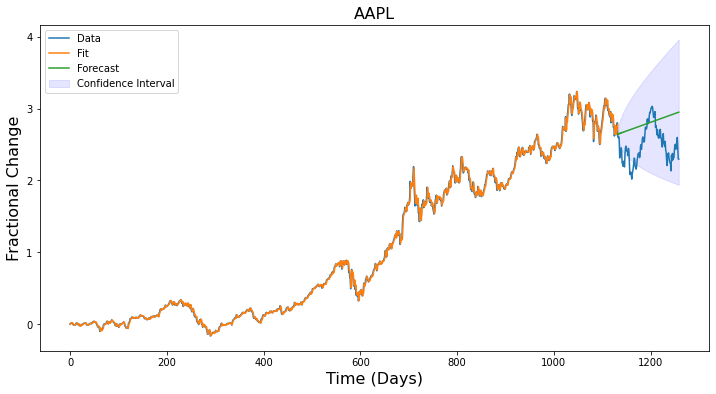

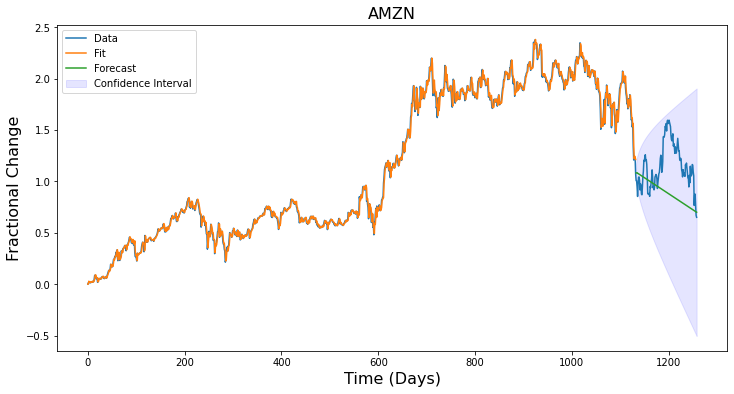

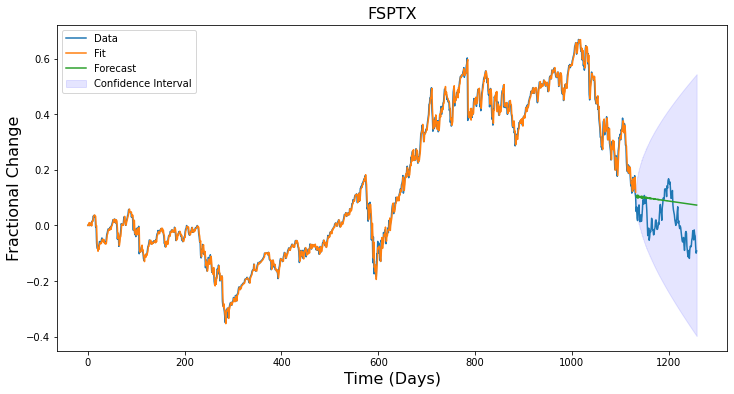

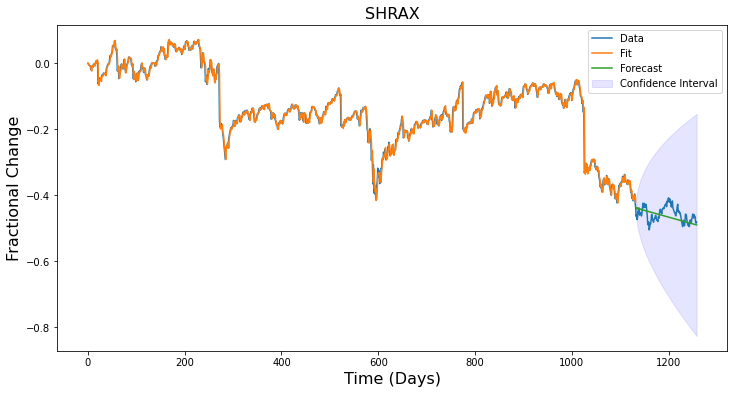

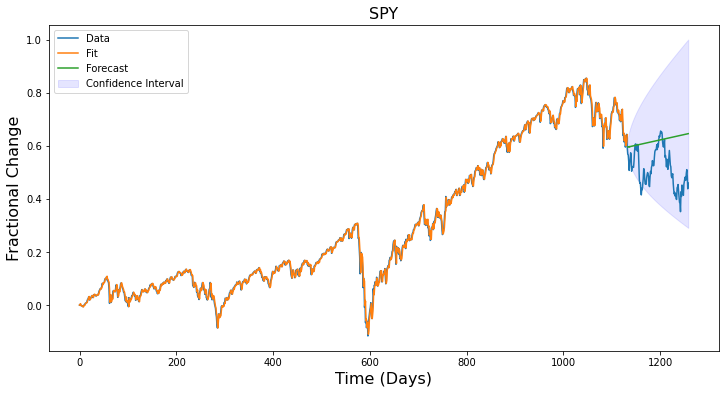

In [114]:
ARIMAError = []
ARIMAConf = []

for i in range(1,len(series)):
    
    thisSeries = data[series[i]]
    t = np.arange(0,len(thisSeries),1)

    trainX = t[:int(.9*len(thisSeries))]
    testX = t[int(.9*len(thisSeries)):]

    trainY = thisSeries[:int(.9*len(thisSeries))]
    testY = thisSeries[int(.9*len(thisSeries)):]

    fit = ARIMA(trainY, order = (2,2,5)).fit()

    forecast = fit.get_forecast(len(testX)).summary_frame()

    plt.figure(figsize = (12,6))

    plt.plot(t,thisSeries, label = "Data")
    plt.plot(trainX,fit.fittedvalues, label = "Fit")
    plt.plot(testX, forecast["mean"], label = "Forecast")
    plt.xlabel("Time (Days)")
    plt.ylabel("Fractional Change")
    plt.fill_between(testX,(forecast['mean_ci_lower']), (forecast['mean_ci_upper']), color='b', alpha=.1, label = "Confidence Interval")
    plt.title(series[i])
    plt.legend();
    ARIMAError.append(MAPE(forecast["mean"],testY))
    ARIMAConf.append(np.mean(forecast['mean_ci_upper'] - forecast['mean_ci_lower']))
    

# Exponential Smoothing

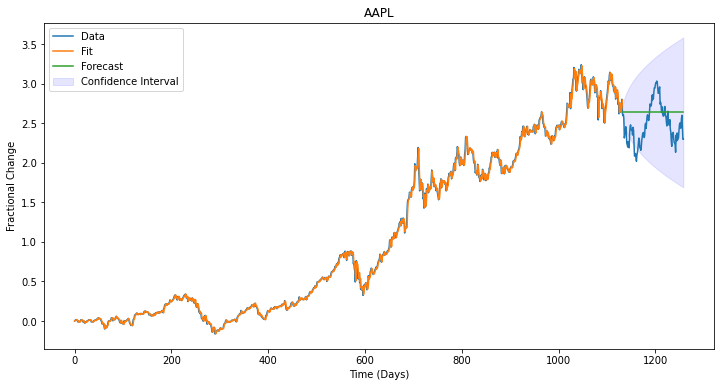

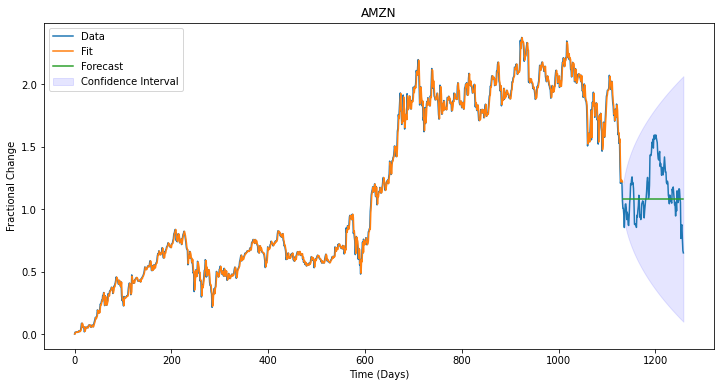

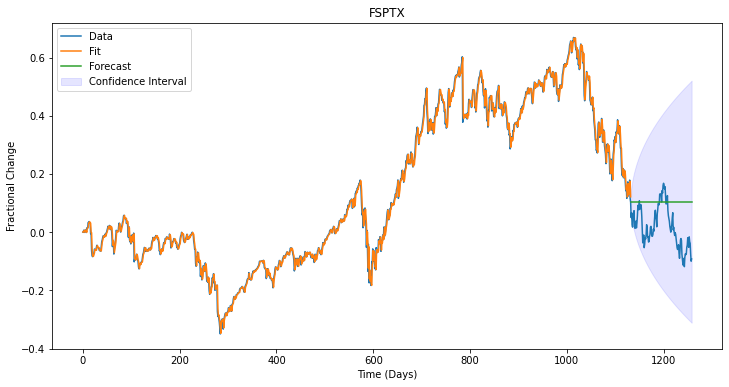

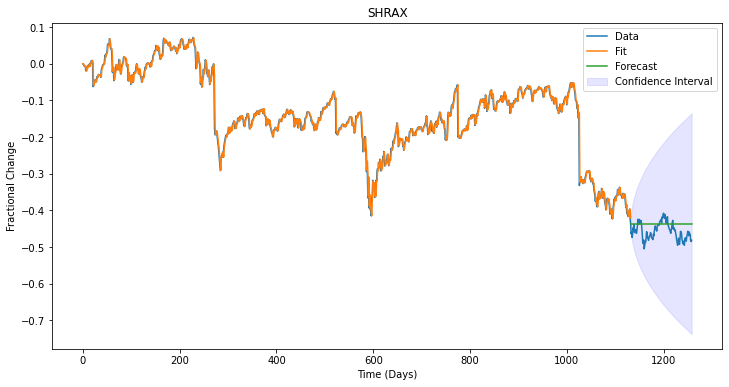

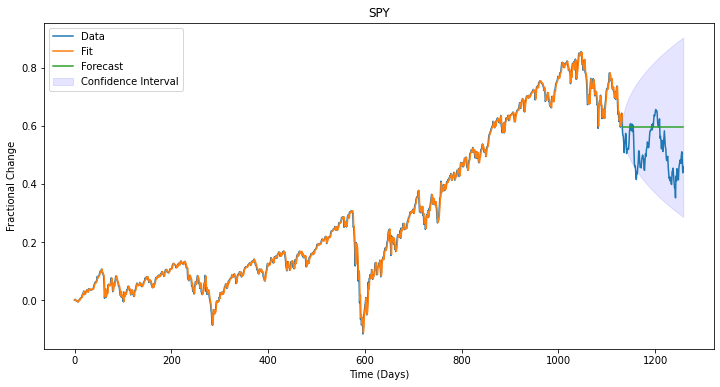

In [109]:
ExpSmoothError = []
ExpSmoothConf = []

for i in range(1,len(series)):
    
    thisSeries = data[series[i]]
    t = np.arange(0,len(thisSeries),1)

    trainX = t[:int(.9*len(thisSeries))]
    testX = t[int(.9*len(thisSeries)):]

    trainY = thisSeries[:int(.9*len(thisSeries))]
    testY = thisSeries[int(.9*len(thisSeries)):]

    fit = ExponentialSmoothing(trainY).fit(disp=0)

    forecast = fit.get_forecast(len(testX)).summary_frame()

    plt.figure(figsize = (12,6))

    plt.plot(t,thisSeries, label = "Data")
    plt.plot(trainX,fit.fittedvalues, label = "Fit")
    plt.xlabel("Time (Days)")
    plt.ylabel("Fractional Change")
    plt.plot(testX, forecast["mean"], label = "Forecast")
    plt.fill_between(testX,(forecast['mean_ci_lower']), (forecast['mean_ci_upper']), color='b', alpha=.1, label = "Confidence Interval")
    plt.title(series[i])
    plt.legend();
    ExpSmoothError.append(MAPE(forecast["mean"],testY))
    ExpSmoothConf.append(np.mean(forecast['mean_ci_upper'] - forecast['mean_ci_lower']))

# Holt's

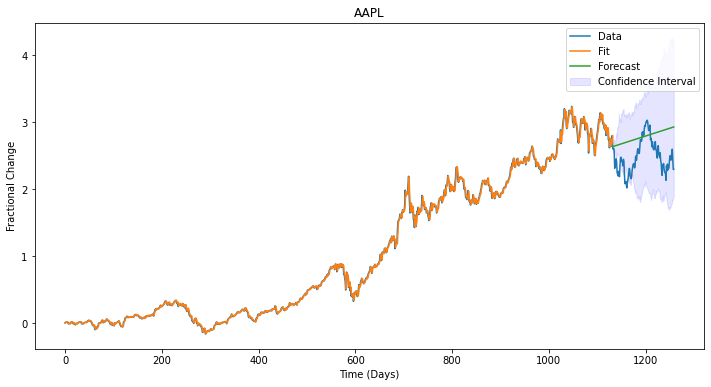

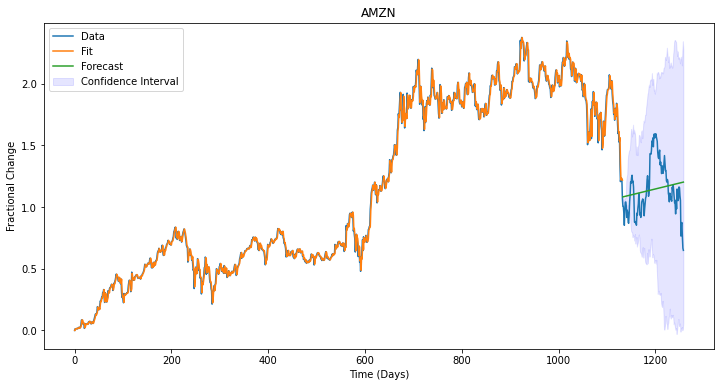

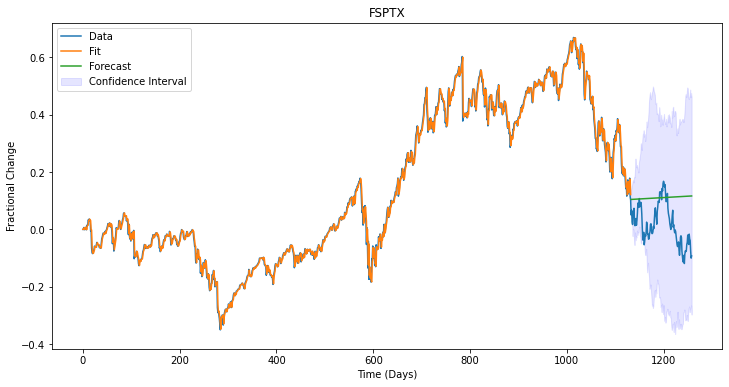

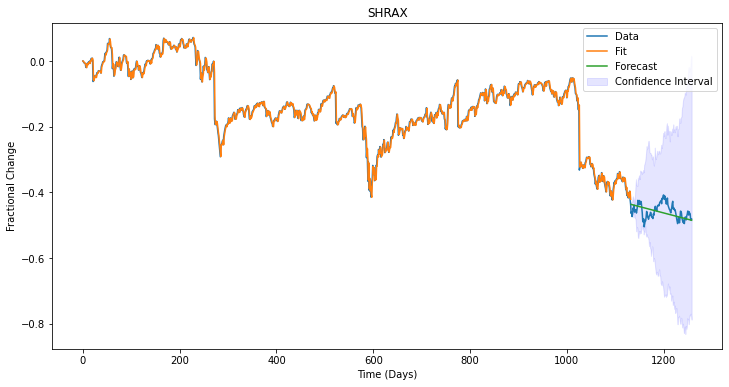

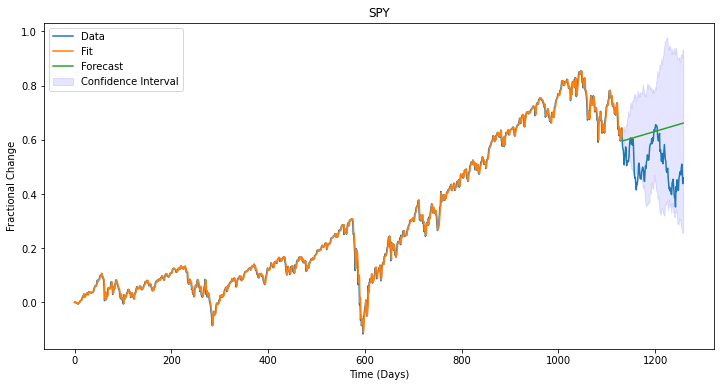

In [111]:
HoltError = []
HoltConf = []

for i in range(1,len(series)):
    
    thisSeries = data[series[i]]
    t = np.arange(0,len(thisSeries),1)

    trainX = t[:int(.9*len(thisSeries))]
    testX = t[int(.9*len(thisSeries)):]

    trainY = thisSeries[:int(.9*len(thisSeries))]
    testY = thisSeries[int(.9*len(thisSeries)):]

    fit = Holt(trainY, initialization_method ='heuristic').fit()

    forecast = fit.forecast(len(testY))
    
    simulations = fit.simulate(len(testY),repetitions = 100)
    
    plt.figure(figsize = (12,6))
    ax = plt.subplot(111)

    plt.plot(t,thisSeries, label = "Data")
    plt.plot(trainX,fit.fittedvalues, label = "Fit")
    plt.plot(testX, forecast, label = "Forecast")
    plt.xlabel("Time (Days)")
    plt.ylabel("Fractional Change")
    plt.fill_between(testX,simulations[np.argmin(simulations.mean())], simulations[np.argmax(simulations.mean())], color='b', alpha=.1, label = "Confidence Interval")
    plt.title(series[i])
    plt.legend()

    HoltError.append(MAPE(forecast,testY))
    HoltConf.append(simulations[np.argmax(simulations.mean())].mean() - simulations[np.argmin(simulations.mean())].mean())
    

    

# Analysis

In [96]:
errors = pd.DataFrame(np.array([ARIMAError,ExpSmoothError, HoltError]).T,
                    columns = ["ARIMA Error", "Exp Smooth Error", "Holt Error"])

In [97]:
errors

#ARIMA First 2
#EXP smooth last 3


,ARIMA Error,Exp Smooth Error,Holt Error
0,0.123924,0.093857,0.121006
1,0.343083,0.158441,0.149879
2,0.972526,0.899384,0.883750
3,0.044935,0.059009,0.043108
4,0.174731,0.149917,0.183083


0: Exp Smooth
1: Holt
2: Holt
3: Holt
4: Exp Smooth

In [101]:
conf = pd.DataFrame(np.array([ARIMAConf,ExpSmoothConf, HoltConf]).T,
                    columns = ["ARIMA Confidence", "Exp Smooth Confidence", "Holt Confidence"])

In [102]:
conf

,ARIMA Confidence,Exp Smooth Confidence,Holt Confidence
0,1.298766,1.271768,1.031511
1,1.468812,1.320249,1.473377
2,0.604199,0.558614,0.554204
3,0.440456,0.403584,0.431388
4,0.453448,0.414499,0.462440


# Final Forecasts

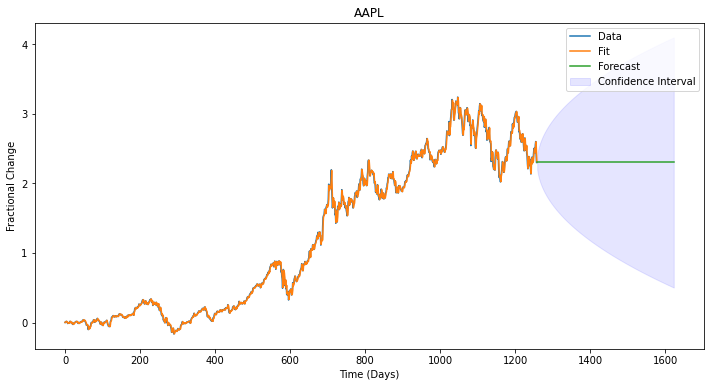

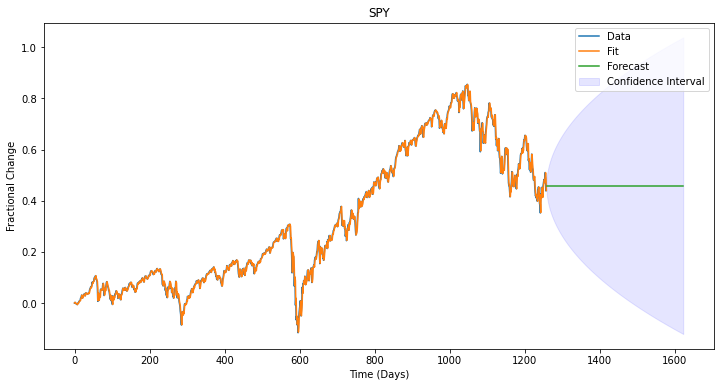

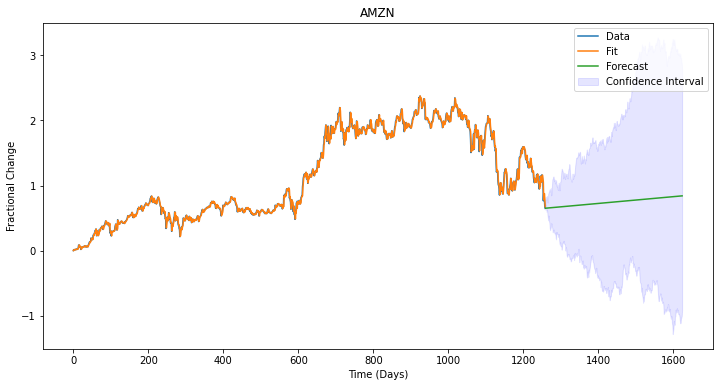

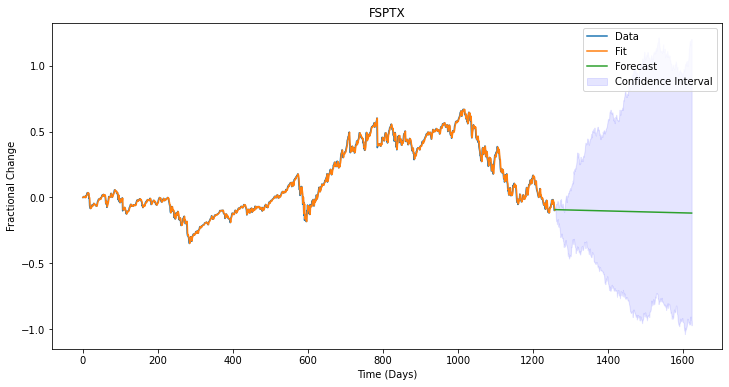

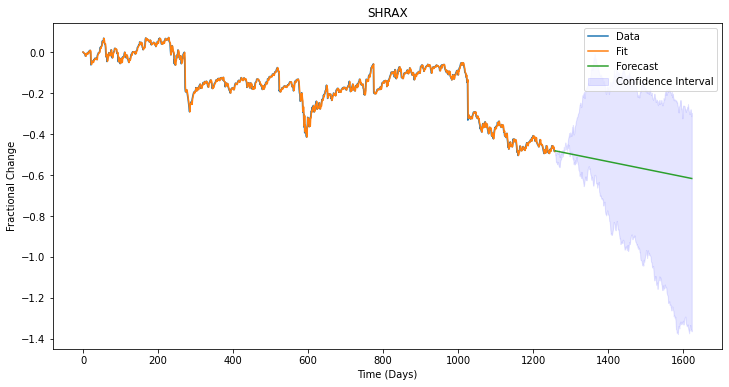

In [112]:
finalForecasts = []
finalConf = []
    
for i in [1,5]:
    
    thisSeries = data[series[i]]
    t = np.arange(0,len(thisSeries),1)
    forecastT = np.arange(len(thisSeries),len(thisSeries)+365,1)
    fit = ExponentialSmoothing(thisSeries).fit(disp=0)

    forecast = fit.get_forecast(365).summary_frame()

    plt.figure(figsize = (12,6))

    plt.plot(t,thisSeries, label = "Data")
    plt.plot(t,fit.fittedvalues, label = "Fit")
    plt.plot(forecastT, forecast["mean"], label = "Forecast")
    plt.xlabel("Time (Days)")
    plt.ylabel("Fractional Change")
    plt.fill_between(forecastT,(forecast['mean_ci_lower']), (forecast['mean_ci_upper']), color='b', alpha=.1, label = "Confidence Interval")
    plt.title(series[i])
    plt.legend();
    finalForecasts.append(forecast["mean"].iloc[-1] - thisSeries.iloc[-1])
    finalConf.append(np.mean(forecast['mean_ci_upper'] - forecast['mean_ci_lower']))
    
for i in [2,3,4]:
    
    thisSeries = data[series[i]]
    t = np.arange(0,len(thisSeries),1)
    forecastT = np.arange(len(thisSeries),len(thisSeries)+365,1)
    fit = Holt(thisSeries, initialization_method ='heuristic').fit()
    
    forecast = fit.forecast(365)
    simulations = fit.simulate(365,repetitions = 100)

    plt.figure(figsize = (12,6))
    ax = plt.subplot(111)

    plt.plot(t,thisSeries, label = "Data")
    plt.plot(t,fit.fittedvalues, label = "Fit")
    plt.plot(forecastT, forecast, label = "Forecast")
    plt.xlabel("Time (Days)")
    plt.ylabel("Fractional Change")
    plt.fill_between(forecastT,simulations[np.argmin(simulations.mean())], simulations[np.argmax(simulations.mean())], color='b', alpha=.1, label = "Confidence Interval")
    plt.title(series[i])
    plt.legend();
    finalForecasts.append(forecast.iloc[-1] - thisSeries.iloc[-1])
    finalConf.append(simulations[np.argmax(simulations.mean())].mean() - simulations[np.argmin(simulations.mean())].mean())
    

In [106]:
#AAPL, SPY, AMZN, FSPTX, SHRAX

finalForecasts

[0.0006650412122768401,
 -0.0008352043565477696,
 0.19127637928033847,
 -0.02672398523375054,
 -0.13552756063552723]

In [107]:
finalConf

[2.399932326715811,
 0.7750259380065895,
 2.3784299775415896,
 0.9601714333525901,
 0.7737798829108098]